# Rotten Tomatoes Sentiment Analysis
Conducting sentiment analysis (pos/neg) on the Rotten Tomatoes dataset from HuggingFace.

## Setup

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# HuggingFace
import datasets

# Transformers
from transformers import AutoTokenizer

# Progress report
from tqdm.notebook import tqdm

In [ ]:
# Setting seeds
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load Data

In [2]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",
                                                               split=["train", "validation", "test"])
train_data, validation_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 8530
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }))

In [ ]:
# Checking data example
train_data[0]

In [ ]:
# Data features
train_data.features

In [7]:
# Changing train data into df form
train_df = pd.DataFrame(train_data)
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'id'}, inplace=True)
train_df

,id,text,label
0,0,the rock is destined to be the 21st century's ...,1
1,1,"the gorgeously elaborate continuation of "" the...",1
2,2,effective but too-tepid biopic,1
3,3,if you sometimes like to go to the movies to h...,1
4,4,"emerges as something rare , an issue movie tha...",1
...,...,...,...
8525,8525,any enjoyment will be hinge from a personal th...,0
8526,8526,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,hardly a nuanced portrait of a young woman's b...,0
8528,8528,"interminably bleak , to say nothing of boring .",0


## EDA

In [ ]:
pd.DataFrame(train_data['label']).value_counts().plot(kind='bar')

We can see that there is an equal distribution between movies that have positive reviews and movies that have negative reviews in the training set.

## NLTK
We will use the NLTK library to conduct sentiment analysis.

In [4]:
# Create instance of Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Example
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
# Another example
sia.polarity_scores("I am so sad")

In [5]:
# Applying polarity scores to the entire train_df
results = {}
for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    text = row['text']
    myid = row['id']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/8530 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(train_df, how='inner', left_on='id', right_on='id')
vaders

,id,neg,neu,pos,compound,text,label
0,0,0.000,0.918,0.082,0.3612,the rock is destined to be the 21st century's ...,1
1,1,0.000,0.758,0.242,0.8069,"the gorgeously elaborate continuation of "" the...",1
2,2,0.000,0.594,0.406,0.2617,effective but too-tepid biopic,1
3,3,0.000,0.633,0.367,0.8271,if you sometimes like to go to the movies to h...,1
4,4,0.086,0.650,0.264,0.6592,"emerges as something rare , an issue movie tha...",1
...,...,...,...,...,...,...,...
8525,8525,0.101,0.786,0.113,0.0644,any enjoyment will be hinge from a personal th...,0
8526,8526,0.052,0.796,0.153,0.4897,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,0.156,0.844,0.000,-0.3400,hardly a nuanced portrait of a young woman's b...,0
8528,8528,0.000,0.754,0.246,0.2411,"interminably bleak , to say nothing of boring .",0


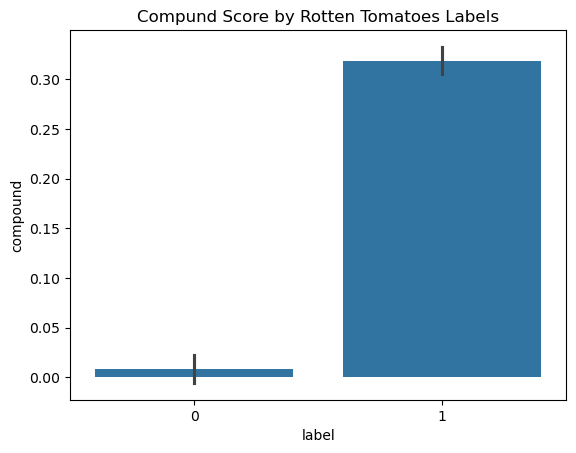

In [15]:
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compund Score by Rotten Tomatoes Labels')
plt.show()

## Tokenizer

In [ ]:
# Create tokenizer from a pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Use map function to tokenize entire dataset
train_data = train_data.map(lambda examples: tokenizer(examples["text"], return_tensors = 'np'), batched=True)

# Display example
train_data[0]

In [ ]:
# Data features after tokenizing
train_data.features